In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch
from tqdm import tqdm

from diffdrr.drr import DRR
from diffdrr.data import load_example_ct
from diffdrr.metrics import XCorr2
from diffdrr.visualization import plot_drr

## Utility functions for the simulation

- Generate ground truth DRR
- Function for generating estimated DRRs
- Functions for scoring (Negative NCC and L2-norm)

Interesting implementation detail here: the output of the forward pass, `drr()`, has to be computed with `torch.no_grad`. Otherwise, the individual computational graph used to generate each DRR will be stored in GPU memory and cause a CUDA error! Note that when normally training a network, each backward pass automatically clears the graph, so these memory issues are not a concern.

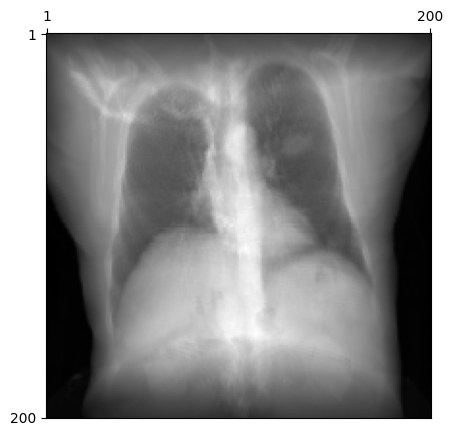

In [ ]:
#|cuda
# Read in the volume
volume, spacing = load_example_ct()
drr = DRR(volume, spacing, sdr=300.0, height=200, delx=4.0).to("cuda" if torch.cuda.is_available() else "cpu")

# Get parameters for the detector
theta, phi, gamma = torch.pi, 0.0, torch.pi / 2
bx, by, bz = torch.tensor(volume.shape) * torch.tensor(spacing) / 2
rotations = torch.tensor([[theta, phi, gamma]])
translations = torch.tensor([[bx, by, bz]])

# Make the DRR
drr.move_carm(rotations, translations)
with torch.no_grad():
    target_drr = drr()
ax = plot_drr(target_drr)
plt.show()

In [ ]:
# Scoring functions
xcorr2 = XCorr2(zero_mean_normalized=True)

def get_normxcorr2(theta, phi, gamma, bx, by, bz):
    drr.move_carm(
        torch.tensor([[theta, phi, gamma]]),
        torch.tensor([[bx, by, bz]]),
    )
    with torch.no_grad():
        moving_drr = drr()
    return xcorr2(target_drr, moving_drr)

## Negative Normalized XCorr

In [ ]:
# NCC for the XYZs
xs = torch.arange(-15., 16.)
ys = torch.arange(-15., 16.)
zs = torch.arange(-15., 16.)

# Get coordinate-wise correlations
xy_corrs = []
for x in tqdm(xs):
    for y in ys:
        xcorr = get_normxcorr2(theta, phi, gamma, bx+x, by+y, bz)
        xy_corrs.append(-xcorr)
XY = torch.tensor(xy_corrs).reshape(len(xs), len(ys))
        
xz_corrs = []
for x in tqdm(xs):
    for z in zs:
        xcorr = get_normxcorr2(theta, phi, gamma, bx+x, by, bz+z)
        xz_corrs.append(-xcorr)
XZ = torch.tensor(xz_corrs).reshape(len(xs), len(zs))
        
yz_corrs = []
for y in tqdm(ys):
    for z in zs:
        xcorr = get_normxcorr2(theta, phi, gamma, bx, by+y, bz+z)
        yz_corrs.append(-xcorr)
YZ = torch.tensor(yz_corrs).reshape(len(ys), len(zs))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:34<00:00,  1.11s/it]


In [ ]:
# NCC for the angles
t_angles = torch.arange(-torch.pi/4, torch.pi/4, step=.05)
p_angles = torch.arange(-torch.pi/4, torch.pi/4, step=.05)
g_angles = torch.arange(-torch.pi/8, torch.pi/8, step=.05)

# Get coordinate-wise correlations
tp_corrs = []
for t in tqdm(t_angles):
    for p in p_angles:
        xcorr = get_normxcorr2(theta+t, phi+p, gamma, bx, by, bz)
        tp_corrs.append(-xcorr)
TP = torch.tensor(tp_corrs).reshape(len(t_angles), len(p_angles))
        
tg_corrs = []
for t in tqdm(t_angles):
    for g in g_angles:
        xcorr = get_normxcorr2(theta+t, phi, gamma+g, bx, by, bz)
        tg_corrs.append(-xcorr)
TG = torch.tensor(tg_corrs).reshape(len(t_angles), len(g_angles))
        
pg_corrs = []
for p in tqdm(p_angles):
    for g in g_angles:
        xcorr = get_normxcorr2(theta, phi+p, gamma+g, bx, by, bz)
        pg_corrs.append(-xcorr)
PG = torch.tensor(pg_corrs).reshape(len(p_angles), len(g_angles))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:18<00:00,  1.69it/s]


/data/vision/polina/users/vivekg/utils/mambaforge/envs/diffdrr/lib/python3.11/site-packages/torch/functional.py:505: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3490.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


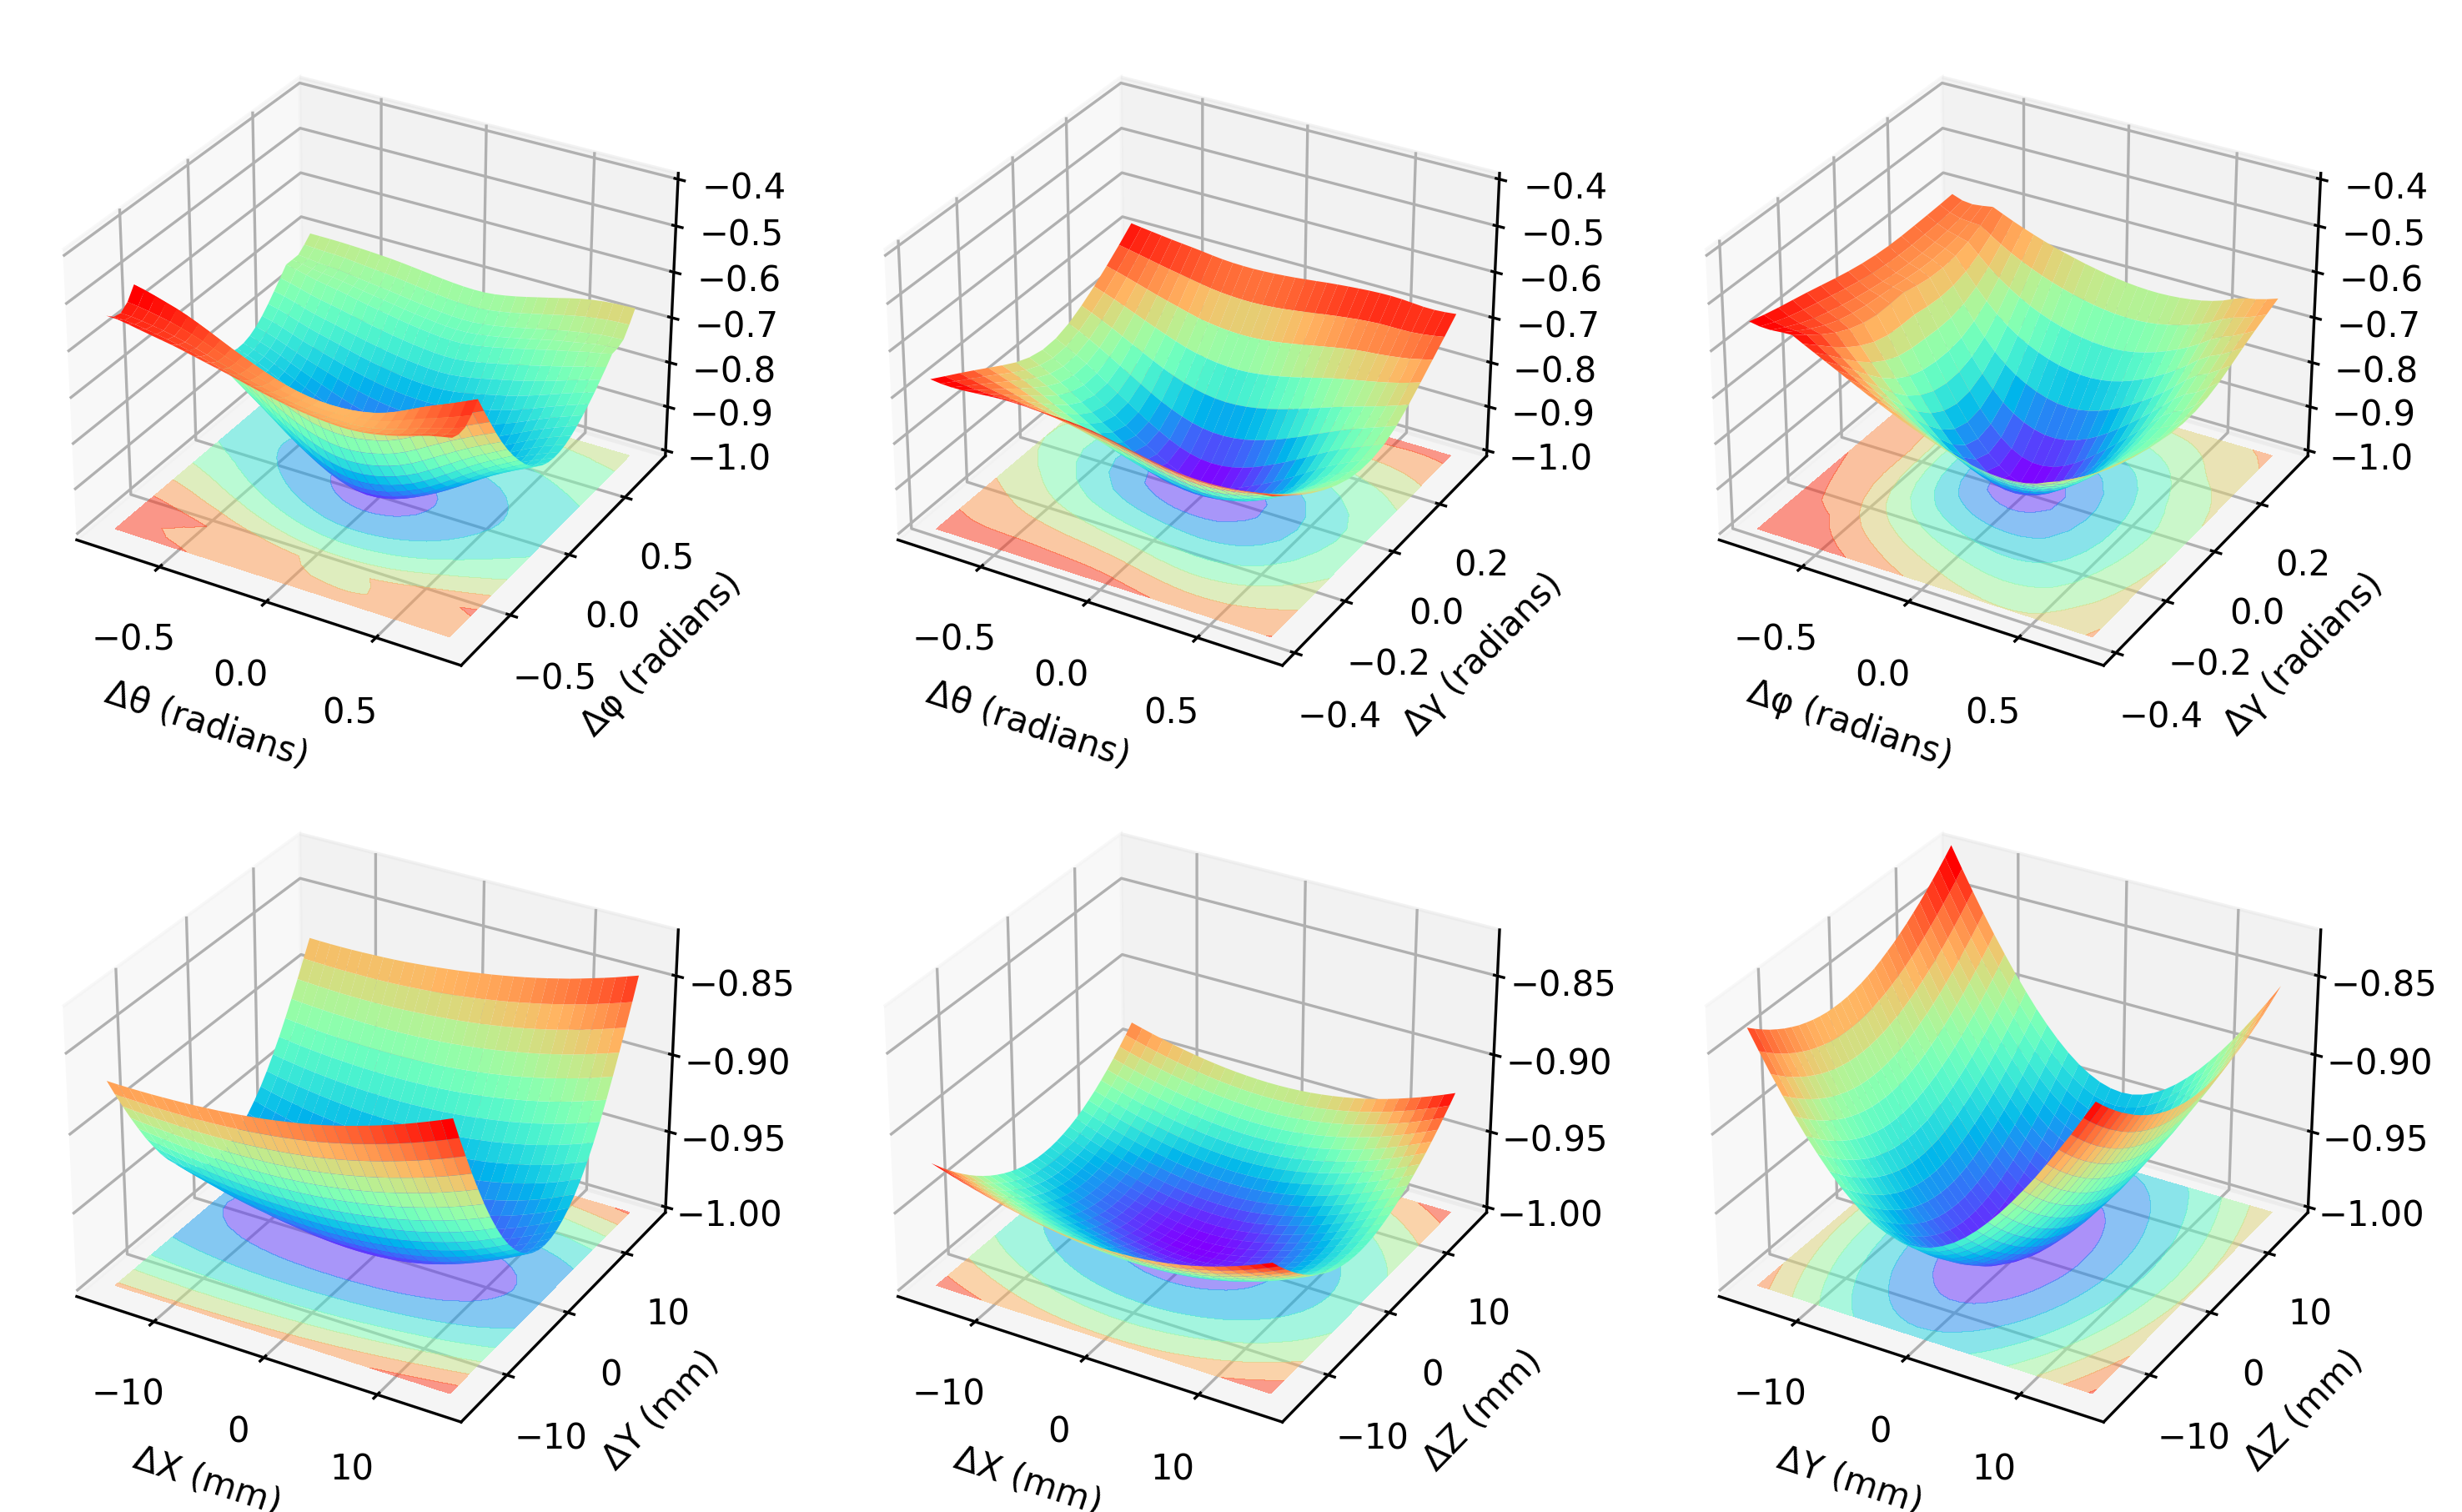

In [ ]:
# Make the plots

# XYZ
xyx, xyy = torch.meshgrid(xs, ys)
xzx, xzz = torch.meshgrid(xs, zs)
yzy, yzz = torch.meshgrid(ys, zs)

fig = plt.figure(figsize=3*plt.figaspect(1.2/1), dpi=300)

ax = fig.add_subplot(1, 3, 1, projection='3d')
ax.contourf(xyx, xyy, XY, zdir="z", offset=-1, cmap=plt.get_cmap('rainbow'), alpha=0.5)
ax.plot_surface(xyx, xyy, XY, rstride=1, cstride=1, cmap=plt.get_cmap('rainbow'))
ax.set_xlabel('ΔX (mm)')
ax.set_ylabel('ΔY (mm)')
ax.set_zlim3d(-1., -0.825)

ax = fig.add_subplot(1, 3, 2, projection='3d')
ax.contourf(xzx, xzz, XZ, zdir="z", offset=-1, cmap=plt.get_cmap('rainbow'), alpha=0.5)
ax.plot_surface(xzx, xzz, XZ, rstride=1, cstride=1, cmap=plt.get_cmap('rainbow'))
ax.set_xlabel('ΔX (mm)')
ax.set_ylabel('ΔZ (mm)')
ax.set_zlim3d(-1., -0.825)

ax = fig.add_subplot(1, 3, 3, projection='3d')
ax.contourf(yzy, yzz, YZ, zdir="z", offset=-1, cmap=plt.get_cmap('rainbow'), alpha=0.5)
ax.plot_surface(yzy, yzz, YZ, rstride=1, cstride=1, cmap=plt.get_cmap('rainbow'))
ax.set_xlabel('ΔY (mm)')
ax.set_ylabel('ΔZ (mm)')
ax.set_zlim3d(-1., -0.825)


# Angles
xyx, xyy = torch.meshgrid(t_angles, p_angles)
xzx, xzz = torch.meshgrid(t_angles, g_angles)
yzy, yzz = torch.meshgrid(p_angles, g_angles)

ax = fig.add_subplot(2, 3, 1, projection='3d')
ax.contourf(xyx, xyy, TP, zdir="z", offset=-1, cmap=plt.get_cmap('rainbow'), alpha=0.5)
ax.plot_surface(xyx, xyy, TP, rstride=1, cstride=1, cmap=plt.get_cmap('rainbow'))
ax.set_xlabel('Δθ (radians)')
ax.set_ylabel('Δφ (radians)')
ax.set_zlim3d(-1., -0.4)

ax = fig.add_subplot(2, 3, 2, projection='3d')
ax.contourf(xzx, xzz, TG, zdir="z", offset=-1, cmap=plt.get_cmap('rainbow'), alpha=0.5)
ax.plot_surface(xzx, xzz, TG, rstride=1, cstride=1, cmap=plt.get_cmap('rainbow'))
ax.set_xlabel('Δθ (radians)')
ax.set_ylabel('Δγ (radians)')
ax.set_zlim3d(-1., -0.4)

ax = fig.add_subplot(2, 3, 3, projection='3d')
ax.contourf(yzy, yzz, PG, zdir="z", offset=-1, cmap=plt.get_cmap('rainbow'), alpha=0.5)
ax.plot_surface(yzy, yzz, PG, rstride=1, cstride=1, cmap=plt.get_cmap('rainbow'))
ax.set_xlabel('Δφ (radians)')
ax.set_ylabel('Δγ (radians)')
ax.set_zlim3d(-1., -0.4)

plt.show()